# TrainingData:

| File | Description |
|------|---------------------------|
| Train16_PBED2.xyz | final training set computed with PBE+D2 |
| Train16_PBED3.xyz | final training set computed with PBE+D3 |
| dft.py | Python script used to compute PBE+D2 values with CASTEP |

The atomic configurations stored in the two training sets are identical, while the properties (energy, forces, virials) are computed with different levels of theory. Details can be found in **Table 2** of the **main paper**. The Python script **dft.py** employs [Workflow](https://github.com/libAtoms/workflow) to automatically create DFT jobs on a cluster and parallelize the calculations. The script can be called using: `python dft.py input_configs.xyz output_configs.xyz job_name`

The atomic configurations data is stored using the [extxyz](https://wiki.fysik.dtu.dk/ase/ase/io/formatoptions.html#extxyz) file format and can be accessed using [ASE](https://wiki.fysik.dtu.dk/ase/index.html) as shown below:

In [1]:
from ase.io import read

db = read('../upload/TrainingData/Train16_PBED2.xyz', ':')
db[912].info

{'Gen': 15,
 'Samp': 'Gen14/DS-MD',
 'Nmols': 19,
 'Comp': 'EC(6):EMC(13)',
 'Temp': 500.0,
 'Dens': 0.8622551322594957,
 'energy': -38128.1209491,
 'virial': array([[-12.07985292, -10.53270928,   4.9560076 ],
        [-10.53270928,  -3.95274595,  20.35750794],
        [  4.9560076 ,  20.35750794,   7.92295331]])}

Each atomic configuration stores the information layed out in **Table 2** of the **main paper**:

- generation at which those configs were added (**Gen**): so, for example, the training set at **Gen14** includes all configs with $\rm Gen<=14$  
- sampling method (**Samp**): sampling method **Gen14/DS-MD** means these configs were obtained by carrying out MD simulations with GAP model **Gen14/DS**  
- number of molecules (**Nmols**)  
- molecular composition (**Comp**): for example **EC(6):EMC(13)** means 6 EC molecules and 13 EMC molecules  
- temperature in Kelvin (**Temp**)  
- density in $\rm g/cm^3$ (**Dens**)  

`energy` ($\rm eV$) and `virial` ($\rm eV$) are *per-config* properties, while `forces` ($\rm eV/\AA$) are *per-atom*.

In [2]:
print(db[912].info['energy'].shape)
print(db[912].info['virial'].shape)
print(db[912].arrays['forces'].shape)

()
(3, 3)
(255, 3)


Here is an example Python script to illustrate the composition of the training set:

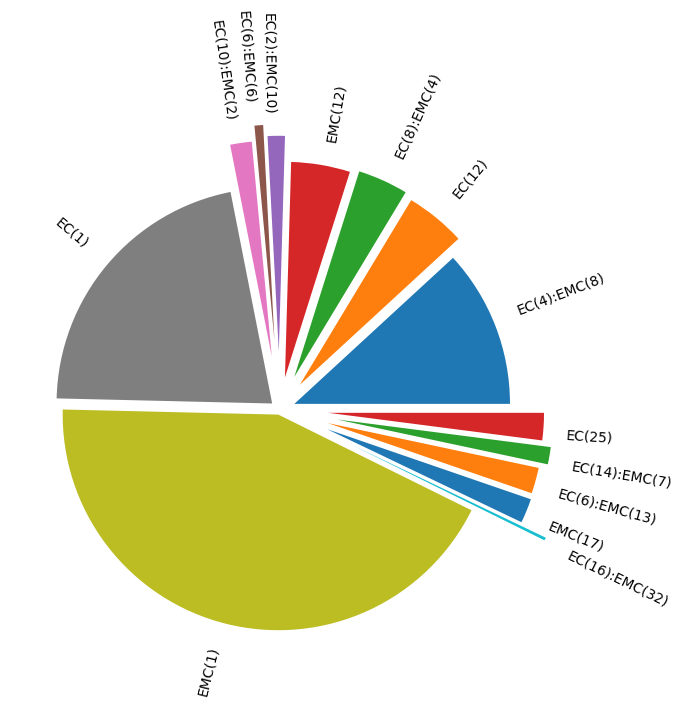

In [3]:

from collections import Counter
from matplotlib import pyplot as plt
import numpy as np

Comps = [at.info['Comp'] for at in db]
Stats = Counter(Comps)

del Stats['H(1)'] #remove isolated H atom
del Stats['C(1)'] #remove isolated C atom
del Stats['O(1)'] #remove isolated O atom
del Stats['EC(4):EMC(7)---UNK_C3H5O3(1):UNK_CH3(1)']  #remove broken EMC molecule (3 configs) originating from a Volume-Scan, SI figure 17

plt.figure(figsize=(7,7))
plt.pie(Stats.values(), labels=Stats.keys(), explode=10/(25+np.array(list(Stats.values()))), rotatelabels =True);

Some useful Python functionality that was developed for this **paper** can be found in the experimental package **[aseMolec](https://github.com/imagdau/aseMolec)**. Use with caution!

In [4]:
from aseMolec import extAtoms as ea

print(ea.get_E0(db))

{'H': -12.353708076955, 'C': -148.1794822322, 'O': -431.46315818255}


The first three configurations are **isolated atoms**: H, C and O and store the isolated atom energies.


# GAPmodels:

| Directory | Description |
|------|---------------------------|
| Gen16DS_PBED2 | Double SOAP trained on the Train16_PBED2.xyz |
| Gen16DS_PBED3 | Double SOAP trained on the Train16_PBED3.xyz |
| Gen16DTS_PBED2 | Double Turbo SOAP trained on the Train16_PBED2.xyz |
| Gen16DTS_PBED3 | Double Turbo SOAP trained on the Train16_PBED3.xyz |

GAP models were trained using [QUIP](https://github.com/libAtoms/QUIP) and are stored as xml files. The Python snippet below shows how to inspect the **GAP command** used to train each model:

In [5]:
import xml.etree.ElementTree as ET

tree = ET.parse('../upload/GAPmodels/Gen16DS_PBED2/gapmodel.xml')
root = tree.getroot()
print('gap_fit'+root[1][2].text)

gap_fit atoms_filename=Train16_PBED2.xyz sparse_jitter=1e-10 gap={soap cutoff=3.0 cutoff_transition_width=0.5 n_max=8 l_max=4 delta=0.1 atom_sigma=0.4 zeta=4 n_sparse=2050 normalise=T sparse_method=cur_points add_species covariance_type=dot_product : soap cutoff=6.0 cutoff_transition_width=1.0 n_max=8 l_max=4 delta=0.1 atom_sigma=0.8 zeta=4 n_sparse=2050 normalise=T sparse_method=cur_points add_species covariance_type=dot_product} default_sigma={0.002 0.1 0.01 0.0} energy_parameter_name=energy force_parameter_name=forces virial_parameter_name=virial do_copy_at_file=F sparse_separate_file=T gp_file=gapmodel.xml


The GAP models can be employed to evaluate `energy`, `forces` and `virial` for any atomic configuration using [QUIPPY](https://pypi.org/project/quippy-ase/):

In [6]:
from ase.io import read
from quippy.potential import Potential

at = read('../upload/TrainingData/Train16_PBED2.xyz', '912')
at.calc = Potential(param_filename='../upload/GAPmodels/Gen16DTS_PBED2/gapmodel.xml')

print(at.get_potential_energy()) #energy
# print(-at.get_stress()*at.get_volume()) #virial
# print(at.get_forces()) #forces

-38128.107767508496


# GAPtests

| Directory | Description |
|------|---------------------------|
| RawConfigs | Raw Test Configs (Volume Scans, Liquid Configs and Isolated Molecules) |
| DFT_PBED2 | Test Configs evaluated with PBE+D2 (Volume Scans, Intra/Inter Splits) |
| Gen16DS_PBED2 | Test Configs evaluated with Gen16DS_PBED2 (Volume Scans, Intra/Inter Splits) |
| Gen16DTS_PBED2 | Test Configs evaluated with Gen16DTS_PBED2 (Volume Scans, Intra/Inter Splits) |

## Rigid-molecule Volume Scans

**Volume-scan** tests can be generated using the **[aseMolec](https://github.com/imagdau/aseMolec)** package:

- start from scratch with an atomic configuration:

In [7]:
from ase.io import read
import nglview

# load an atomic config and clear all data (except for lattice, elements and positions)
def load_config():
    at = read('../upload/TrainingData/Train16_PBED2.xyz', '912')
    at.info = {}
    del at.arrays['molID']
    del at.arrays['forces']
    at.wrap()
    return at

at = load_config()
nglview.show_ase(at) #visualize the configuration

NGLWidget()

- now generate a **Volume-scan** as shown below:

In [8]:
import numpy as np
from aseMolec import anaAtoms as aa

# generate Volume-scan
fracs = np.geomspace(0.125, 27.0, 100)
db = aa.scan_vol(at, vol_fracs=fracs, frozen=True)
nglview.show_asetraj(db[::-1])

NGLWidget(max_frame=99)

This was the method used to generate all **Volume-scans** in `GAPtests/RawConfigs/VScan_*`. The raw configs were then evaluated using **PBE+D2** (see `TrainingData/dft.py` example script) as well as using the two **GAP** models trained on **PBE+D2** data. The results of the evaluation can be found in `GAPtests/DFT_PBED2/VScan_*`, `GAPtests/Gen16DS_PBED2/VScan_*` and `GAPtests/Gen16DTS_PBED2/VScan_*` respectively.

The **[aseMolec](https://github.com/imagdau/aseMolec)** package provides a [QUIPPY](https://pypi.org/project/quippy-ase/) wrapper to easily evaluate configs using GAP models:

In [9]:
from quippy.potential import Potential
from aseMolec import evalUtils as eu

VScan = read('../upload/GAPtests/RawConfigs/VScan_33EC_66EMC_config02.xyz', '::3') #read every third config
gap = Potential(param_filename='../upload/GAPmodels/Gen16DTS_PBED2/gapmodel.xml')
eu.eval_gap_quippy(VScan, gap, prog=False)

Here is an example Python script to compare **Volume-scans** evaluated with **PBE+D2** and the two **GAP** models trained on **PBE+D2**:

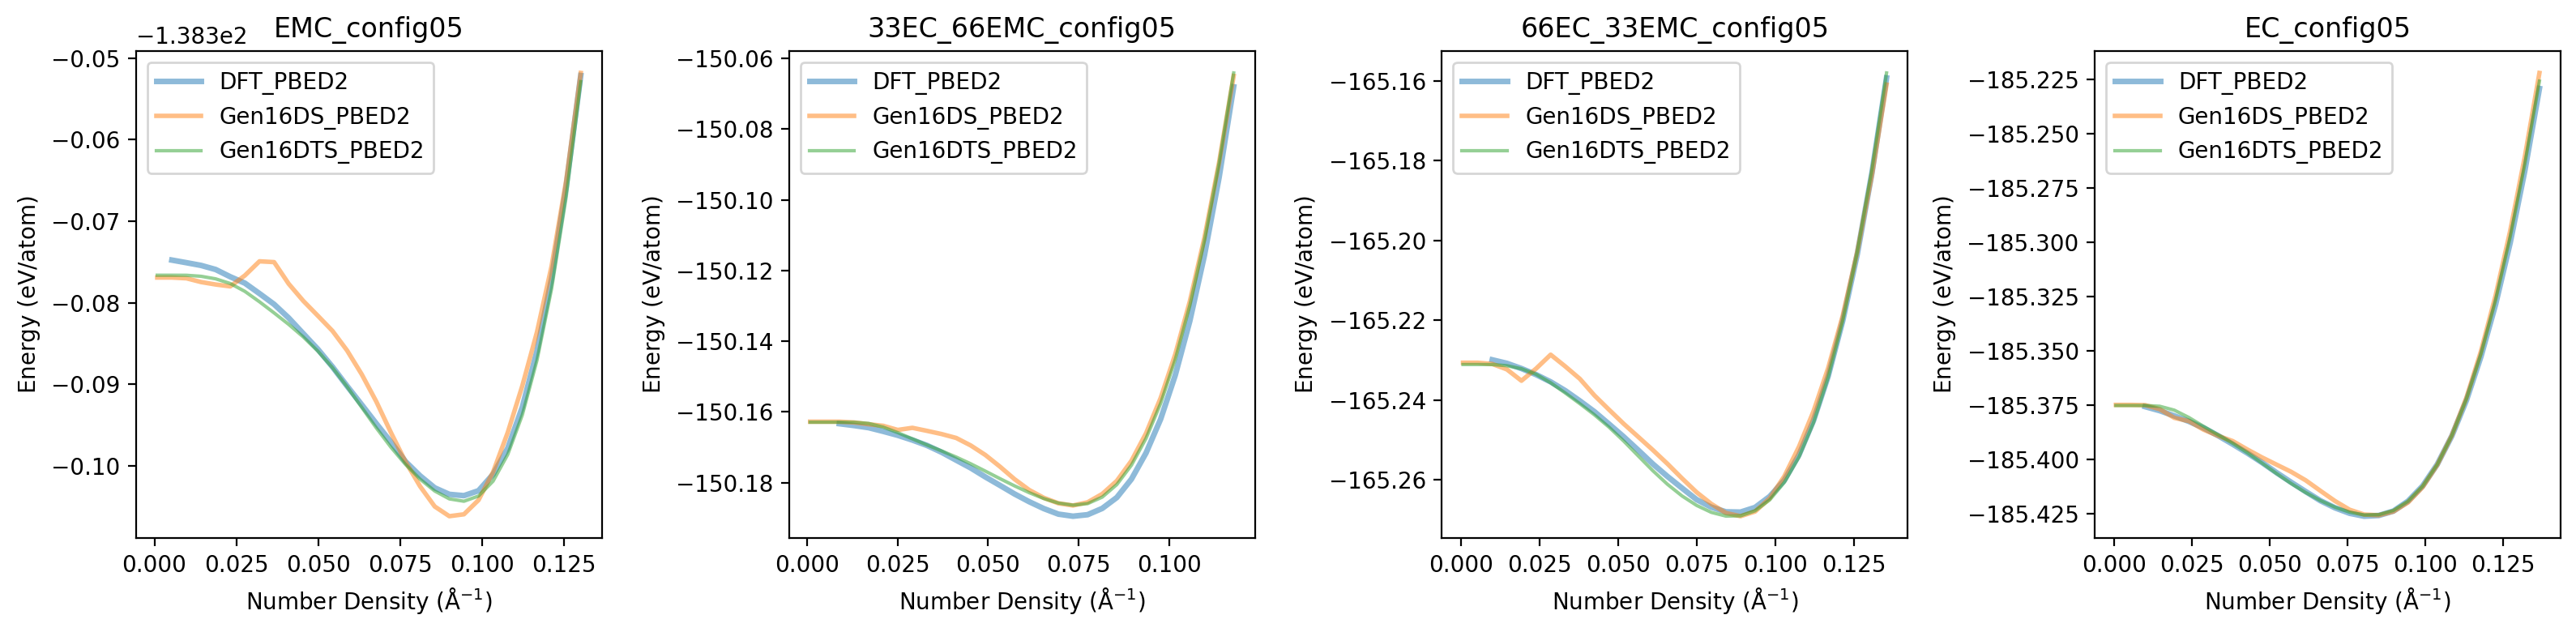

In [10]:
from matplotlib import pyplot as plt
from aseMolec import extAtoms as ea

def plot_vscan(vsname='33EC_66EMC_config03', vspaths=['DFT_PBED2', 'Gen16DS_PBED2', 'Gen16DTS_PBED2']):
    for i, vspath in enumerate(vspaths):
        db = read('../upload/GAPtests/'+vspath+'/VScan_'+vsname+'.xyz', ':')
        num_dens = ea.get_prop(db, 'meth', 'get_volume', peratom=True)**(-1)
        energy = ea.get_prop(db, 'info', 'energy', peratom=True)
        plt.plot(num_dens, energy, label=vspath, linewidth=(3-i)*0.5+1.0, alpha=0.5)
    plt.xlabel(r'Number Density ($\rm \AA^{-1}$)')
    plt.ylabel(r'Energy ($\rm eV/atom$)')
    plt.legend()
    plt.title(vsname)
    plt.tight_layout()

plt.figure(figsize=(16, 4), dpi=200)
plt.subplot(1,4,1)
plot_vscan(vsname='EMC_config05')
plt.subplot(1,4,2)
plot_vscan(vsname='33EC_66EMC_config05')
plt.subplot(1,4,3)
plot_vscan(vsname='66EC_33EMC_config05')
plt.subplot(1,4,4)
plot_vscan(vsname='EC_config05')


## Intra-/Inter- Split

There are two approaches we take to compute the Intra-/Inter- split:

### Approach I

Deconstruct **liquid configs** into **isolated molecules** to compute **Intra**. Obtain **Inter** by subtracting from **Total**.  
This applies to `energy`, `forces` and `virial`.

- the **[aseMolec](https://github.com/imagdau/aseMolec)** package can be used to split **liquid configurations** into **isolated molecules** as shown below:

In [11]:
at = load_config()
db = [at] # a list of liquid configs

# split the liquid configs into list of molecules and organize them into a dictionary by molecule type
# each liquid configuration is assigned a unique ID ('uid') which will be needed for reconstruction
# molecules are identified and receive a 'molID' within each liquid configuration
mol_dict = aa.split_molecs_dict(db)

nglview.show_asetraj(mol_dict['EMC'])

NGLWidget(max_frame=12)

- unpack the dictionary into a list of **isolated molecules** and compute properties (e.g. **Gen16DS_PBED2**) for both liquid and isolate molecules 

In [12]:
smdb = [mol for mol_type in mol_dict for mol in mol_dict[mol_type]]
gap = Potential(param_filename='../upload/GAPmodels/Gen16DTS_PBED2/gapmodel.xml')

eu.eval_gap_quippy(db, gap, prog=False) # energy, forces, virial for the Liquid Config
eu.eval_gap_quippy(smdb, gap, prog=False) # energy, forces, virial for the Isolated Molecules

- use **[aseMolec](https://github.com/imagdau/aseMolec)** functionality to recombine the **liquid configs** with the **isolated molecules**. This will create new fields in `db`, splitting the **Intra/Inter** contributions: `energy` (original on liquid configs), `energy_intram` (sum of isolated molecule energies), `energy_interm` (difference between `energy` and `energy_intram`); similarly for the `virial` and `forces`:

In [13]:
aa.collect_molec_results_dict(db, smdb)
ea.check_keys(db)

['Nmols', 'Comp', 'uid', 'energy', 'virial', 'energy_intram', 'virial_intram', 'energy_interm', 'virial_interm', 'numbers', 'positions', 'molID', 'forces', 'forces_intram', 'forces_interm']


Variations of these function were used to generate all **Intra/Inter** splits in `GAPtests`.  

Specifically, `aa.split_molecs()` was used to generate `GAPtests/RawConfigs/IsolatedMolecs_test40.xyz` from `GAPtests/RawConfigs/LiquidConfigs_test40.xyz`.

The raw configs were then evaluated using **PBE+D2** as well as the two **GAP** models trained on **PBE+D2** data. The results were collected into **Intra/Inter** splits (see `IntraInterSplit_test40.xyz` in `GAPtests/DFT_PBED2`, `GAPtests/Gen16DS_PBED2` and `GAPtests/Gen16DTS_PBED2`) using `aa.collect_molec_results()`.

The **[aseMolec](https://github.com/imagdau/aseMolec)** package provides functionality to compare **Intra/Inter** splits evaluated with two different methods:

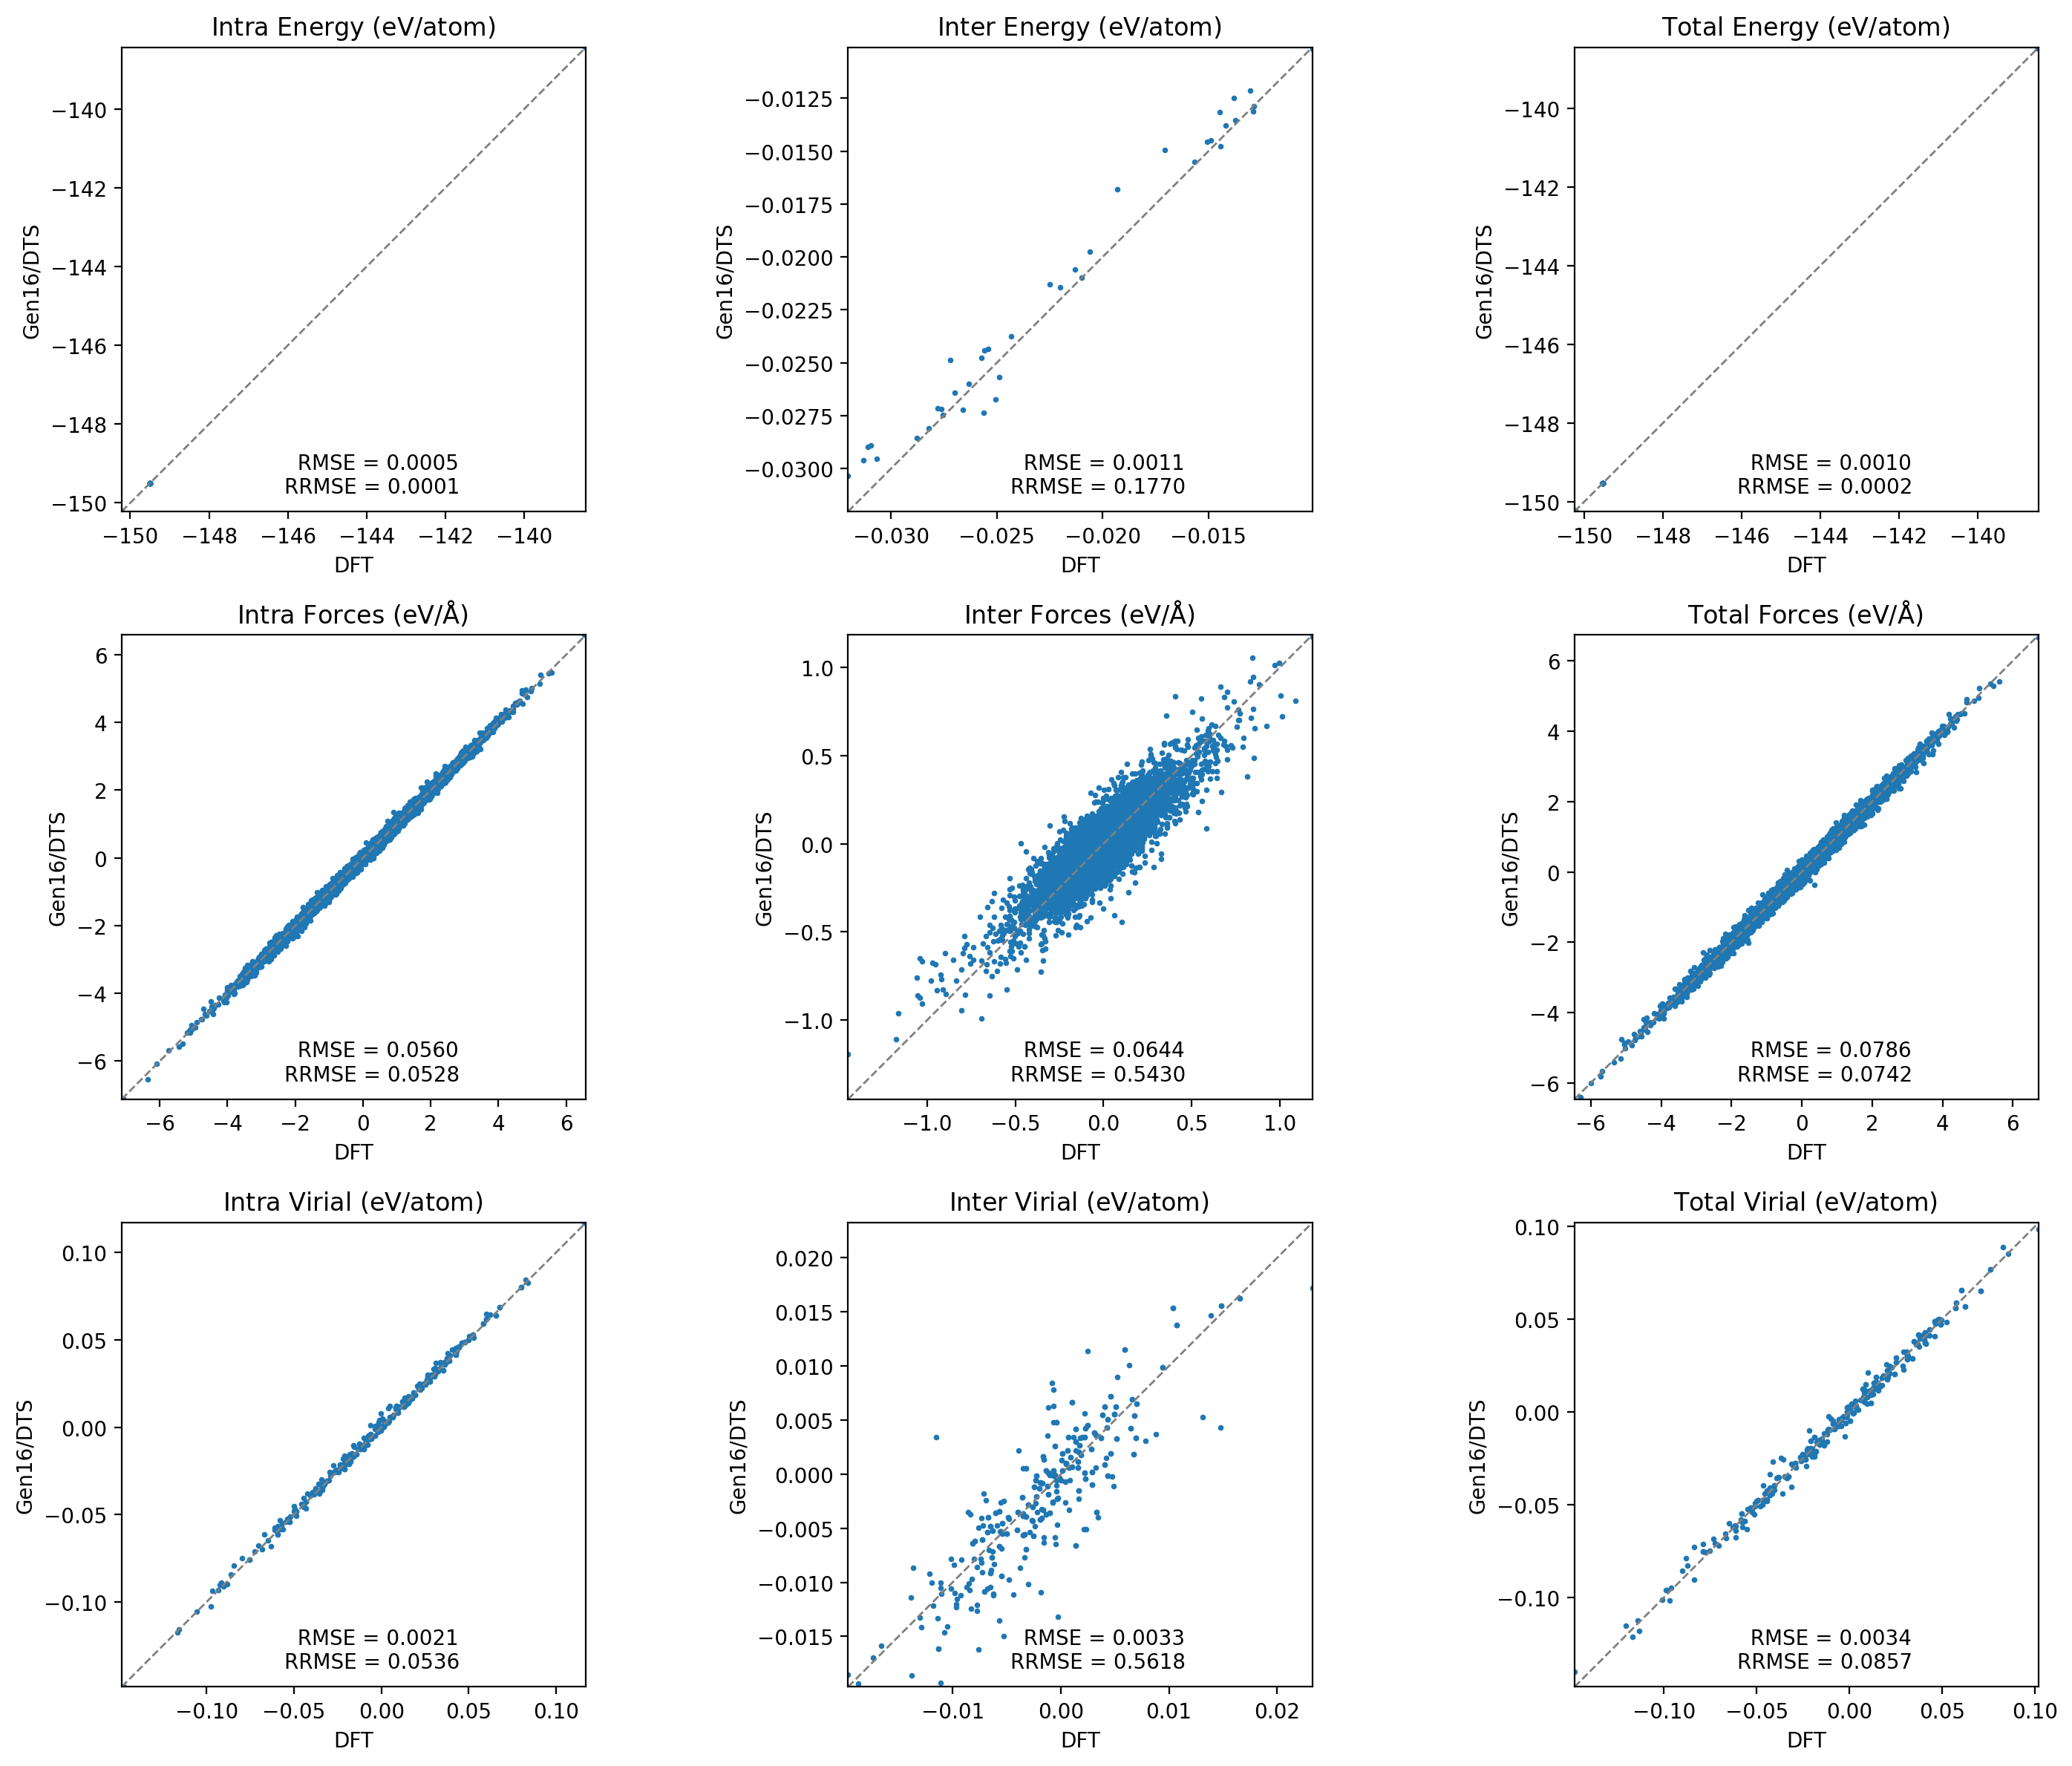

In [14]:
from aseMolec import pltProps as pp

db1 = read('../upload/GAPtests/DFT_PBED2/IntraInterSplit_test40.xyz', ':')
db2 = read('../upload/GAPtests/Gen16DTS_PBED2/IntraInterSplit_test40.xyz', ':')

pp.plot_intra_inter(db1, db2, labs=['DFT', 'Gen16/DTS'])

The function also calculates **root mean square errors (RMSE)** and **relative RMSEs (RRMSE)**

### Approach II

The second approach has the advantage that it **does not require additional computation on the isolated molecules**, but it only performs an **Intra/Inter** split for `forces` but not for `energy` and `virial`. The method can be summarized in the following steps:

1. Identify molecules (labeled **j**).  

2. Within each molecule **j** sum over all atomic forces (labeled **k**) to obtain the **translational** component:
$$F^{\rm trans}_j = \sum_{k \in j} f_{k}$$

3. Redistribute the molecular **translational** force onto individual atoms (labeled **i**) to obtain the atomic **translational** contributions:
$$f^{\rm trans}_i = \frac{m_i}{M_j} F^{\rm trans}_j$$

4. Similarly, compute the torque on the entire molecule:
$$T_j = \sum_{k \in j} f_{k} \times r_{k}$$

5. Compute the atomic **rotational** force contributions that give rise to the given molecular torque:
$$f^{\rm rot}_i = m_i r_i \times (I_j^{\alpha \beta})^{-1} T_j$$

6. Finally compute the **vibrational** contribution as the difference:
$$f^{\rm vib}_i = f_i - f^{\rm trans}_i - f^{\rm rot}_i$$

7. In this approach, the **Inter** is the sum of `trans` and `rot`, while the **Intra** is the `vib` component.

This split can be constructed using the **[aseMolec](https://github.com/imagdau/aseMolec)** package as shown below:

In [15]:
# start with a liquid config and evaluate forces
at = load_config()
db = [at]
eu.eval_gap_quippy(db, gap)

# wrap the molecules over the PBC
aa.wrap_molecs(db)
# aa.extract_molecs will only work correctly if molecules are whole, not split over PBC
smdb = aa.extract_molecs(db, intra_inter=True)
ea.check_keys(db)

Evaluating config: 0
['energy', 'virial', 'Nmols', 'Comp', 'numbers', 'positions', 'forces', 'molID', 'forces_trans', 'forces_rot', 'forces_vib']


The function creates new fields `forces_trans` ($f^{\rm trans}_i$), `forces_rot` ($f^{\rm rot}_i$) and `forces_vib` ($f^{\rm vib}_i$) corresponding to the different force components.

Additionally, a new list of configs is generated (`smdb`) corresponding to the centers of mass of the molecules in `db`. This list of configs stores molecular-level information: `masses` ($M_j$), `molSym` (molecule type: EC or EMC), `momInertia` ($I_j^{\alpha \beta}$), `forces` ($F^{\rm trans}_j$) and `torques` ($T_j$):

In [16]:
ea.check_keys(smdb)

['numbers', 'positions', 'masses', 'molSym', 'momInertia', 'forces', 'torques']


The method was used to generate the **Trans/Rot/Vib** splits based the original forces computed with **PBE+D2** and the two **GAP** models trained on **PBE+D2** data as shown below for the DFT data:

In [17]:
db = read('../upload/GAPtests/DFT_PBED2/IntraInterSplit_test40.xyz', ':')
ea.del_prop_by_tag(db, '_intram') # delete Intra/Inter from previous approach
ea.del_prop_by_tag(db, '_interm') # keep the total forces
aa.extract_molecs(db, intra_inter=True) # use the new approach to split into Trans/Rot/Vib
ea.check_keys(db[0:1])

['uid', 'energy', 'virial', 'Nmols', 'Comp', 'numbers', 'positions', 'forces', 'molID', 'forces_trans', 'forces_rot', 'forces_vib']


Results were written to `TransRotVibSplit_test40.xyz` into their respective folders.

The **[aseMolec](https://github.com/imagdau/aseMolec)** package provides functionality to compare **Trans/Rot/Vib** splits evaluated with two different methods:

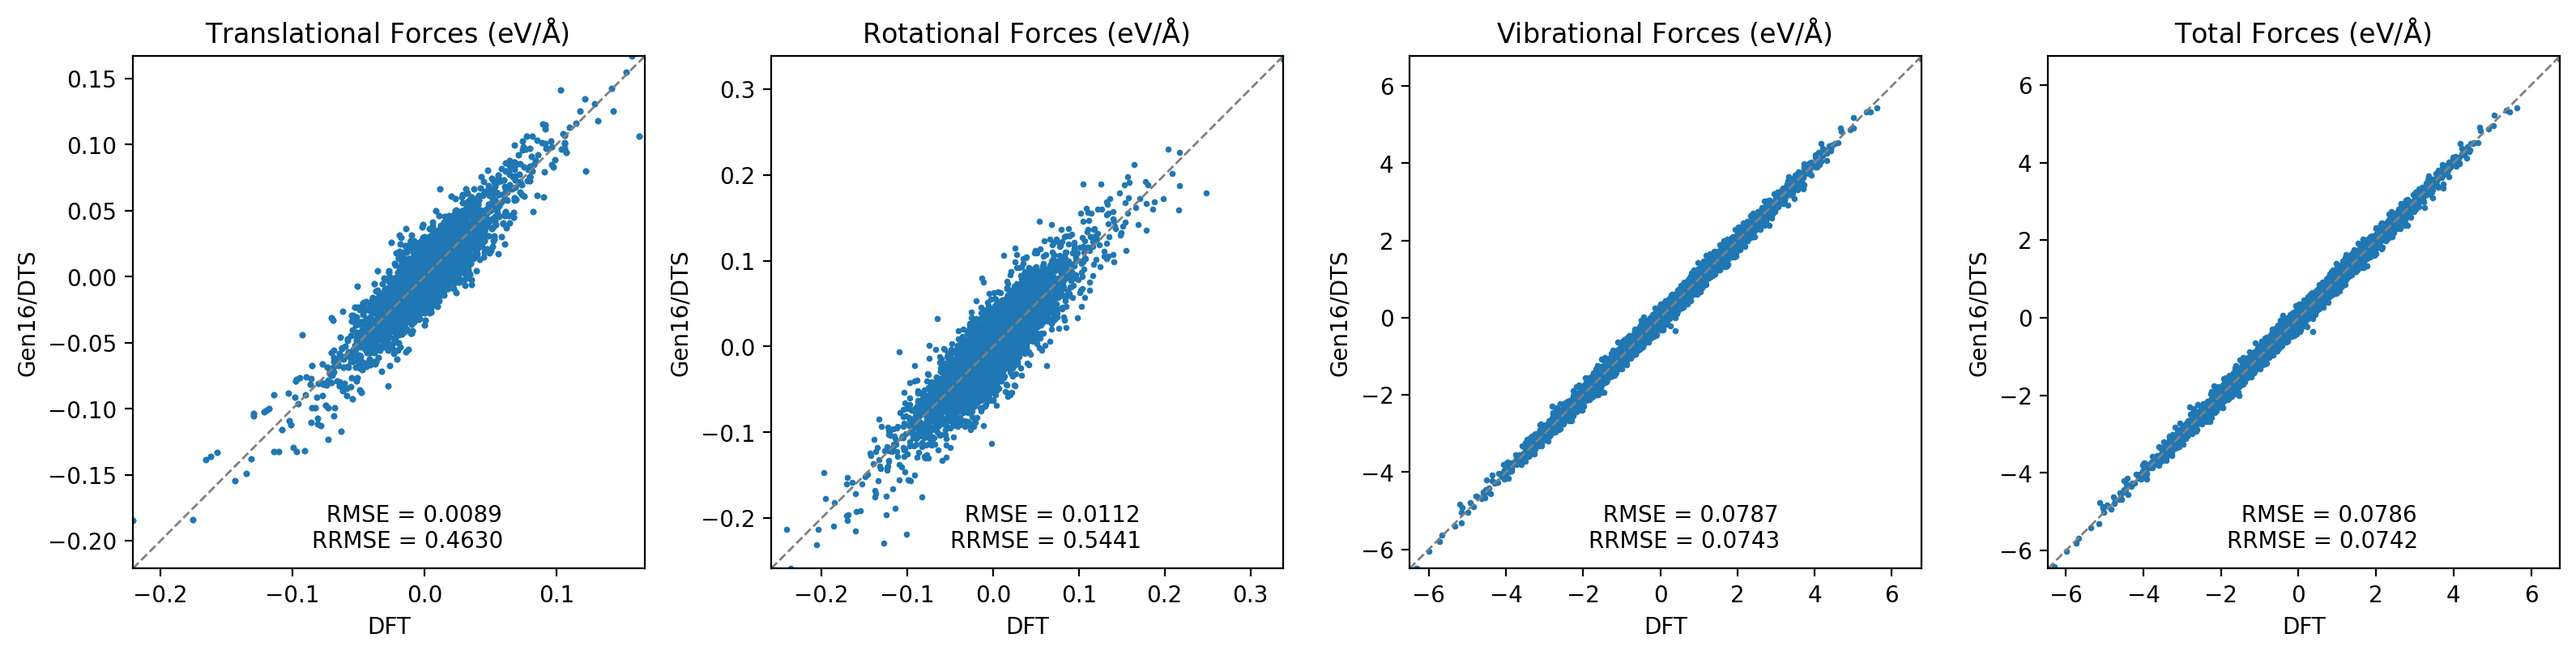

In [18]:
import importlib
importlib.reload(pp)

db1 = read('../upload/GAPtests/DFT_PBED2/TransRotVibSplit_test40.xyz', ':')
db2 = read('../upload/GAPtests/Gen16DTS_PBED2/TransRotVibSplit_test40.xyz', ':')

pp.plot_trans_rot_vib(db1, db2, labs=['DFT', 'Gen16/DTS'])

# MDsimulations

We are providing the results from four different categories of MD simulations in four main directories as shown in this table:

| Directory | Description |
|------|---------------------------|
| 48Molec_100ps_NPT | 48-molecs, 100 ps, NPT test simulations with final GAP models (Gen16) and OPLS <br>**Figure 2** of the **main paper**, **Table 1** and **Figure 6** of the **SI** |
| 1000Atoms_1000ps_NPT | 1000-atoms, 1 ns, NPT production simulations with final GAP model (Gen16/DTS) trained on PBE+D3 <br>**Figure 5** of the **main paper** |
| 48Molec_20ps_NVT | 48-molecs, 20 ps, NVT simulations for comparing to Ab Initio MD (AIMD trajectories included) <br>**Figure 4** of the **main paper**, **Figures 7** and **8** of the **SI** |
| 12Molec_50ps_NEMD | 12-molecs, 50 ps, Non-equilibrium MD simulations used in iterative training (at Gen13) <br>**Figure 5** of the **SI** |

All four directories are structured in a similar way. Each contains sub-directories whose names indicate the method used for dynamics:

`MDsimulations/`  
`├── 1000Atoms_1000ps_NPT`  
`│   ├── Gen16DTS_PBED3`  
`│   └── md.input`  
`├── 12Molec_50ps_NEMD`  
`│   └── Gen12DS_PBED2`  
`│   └── md.input`  
`├── 48Molec_100ps_NPT`  
`│   ├── Gen16DS_PBED2`  
`│   ├── Gen16DS_PBED3`  
`│   ├── Gen16DTS_PBED2`  
`│   ├── Gen16DTS_PBED3`  
`│   ├── OPLS`  
`│   ├── md_gap.input`  
`│   └── md_opls.input`  
`└── 48Molec_20ps_NVT`  
     `├── AIMD_PBED3`  
     `├── Gen16DS_PBED3`  
     `├── Gen16DTS_PBED3`  
     `└── md.input`  

Each sub-directory, for example `Gen16DTS_PBED3`:

`MDsimulations/`  
`├── 1000Atoms_1000ps_NPT`  
`│   ├── Gen16DTS_PBED3`  
`│   │   ├── 100EC_300K.data`  
`│   │   ├── 100EC_300K.lammpstrj`  
`│   │   ├── 100EC_300K.thermo`  
`│   │   ├── 25EC_50EMC_300K.data`  
`│   │   ├── 25EC_50EMC_300K.lammpstrj`  
`│   │   ├── 25EC_50EMC_300K.thermo`  
`.......`  

contains a series of simulations at different compositions and temperatures as indicated by the file names. For each simulation we provide the starting configurations (`*.data`) and trajectories: coordinates (`*.lammpstrj`) and thermodynamic properties (`*.thermo`).

Each directory also contains the [LAMMPS](https://docs.lammps.org/Manual.html) input files (`md*.input`) used to run the simulations. For example, each simulation in `48Molec_100ps_NPT/Gen16DS_PBED2` was run with:  

`lammps -in md_gap.input -var start` **`16EC_32EMC_500K`** `-var temp` **`500`** `-var model` **`Gen16DS_PBED2/gapmodel`**

[ASE](https://wiki.fysik.dtu.dk/ase/index.html) provides functionality to read `*.data` and `*.lammpstrj` files as shown below:


In [19]:
from aseMolec import extAtoms as ea
from aseMolec import anaAtoms as aa
from ase.io.lammpsdata import read_lammps_data

start_config = read_lammps_data('../upload/MDsimulations/48Molec_100ps_NPT/Gen16DS_PBED2/16EC_32EMC_400K_Rep1.data', Z_of_type=[0,1,6,8], style="atomic", sort_by_id=True, units="metal")

aa.wrap_molecs([start_config])
print('Starting Config: ', start_config.info['Comp'])

# the style argument in read_lammps_data informs the formating of atom records in *.data
# use the same as the atom_style used in md.input (e.g. atomic, full ...)
start_config = read_lammps_data('../upload/MDsimulations/12Molec_50ps_NEMD/Gen12DS_PBED2/4EC_8EMC_700K.data', Z_of_type=[0,1,6,8], style="full", sort_by_id=True, units="metal")

aa.wrap_molecs([start_config])
print('Starting Config: ', start_config.info['Comp'], '{:.0f}K'.format(start_config.get_temperature()), '{:.2f}g/cm3'.format(ea.get_density_gcm3(start_config)))

Starting Config:  EC(16):EMC(32)
Starting Config:  EC(4):EMC(8) 673K 0.99g/cm3


In [20]:
from ase.io.lammpsrun import read_lammps_dump_text

#notice in MDsimulations/48Molec_100ps_NPT/md_gap.input, snapshots were written every 100 steps / 100 fs
db = read_lammps_dump_text(fileobj=open('../upload/MDsimulations/48Molec_100ps_NPT/Gen16DS_PBED2/16EC_32EMC_400K_Rep1.lammpstrj'),specorder=['H','C','O'], index=slice(None,None,100)) #read every 100, so every 10 ps
for at in db: at.arrays['forces'] = at.get_forces() #store forces from the calculator

import nglview

aa.wrap_molecs(db)
nglview.show_asetraj(db)


NGLWidget(max_frame=10)

Thermodynamic properties can be read and plotted using the **[aseMolec](https://github.com/imagdau/aseMolec)** package. A simple plotting function for log files (`*.thermo` or `*.msd`):

Text(0, 0.5, 'MSD ($\\rm \\AA$)')

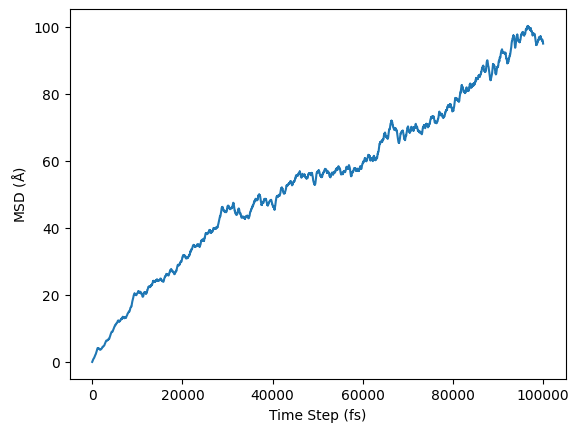

In [21]:
from matplotlib import pyplot as plt
from aseMolec import pltProps as pp

thermo_dict = pp.loadtxttag('../upload/MDsimulations/48Molec_100ps_NPT/Gen16DS_PBED2/16EC_32EMC_400K_Rep1.thermo')
pp.simpleplot(thermo_dict, 0, 5) #plot column 5 vs column 0
plt.xlabel('Time Step (fs)')
plt.ylabel(r'MSD ($\rm \AA$)')

Text(0, 0.5, 'Energy (eV)')

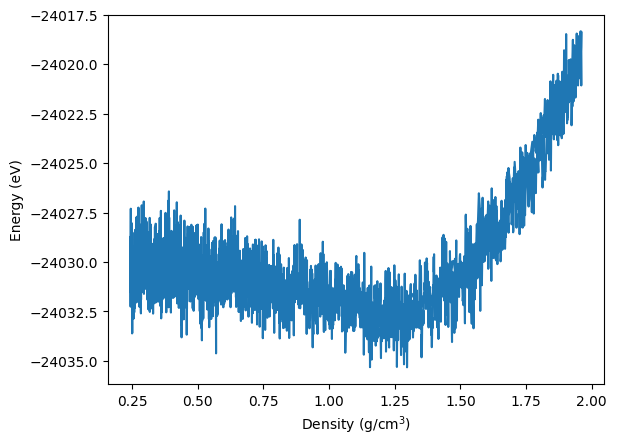

In [22]:
#Non-equilibrium MD:
thermo_dict = pp.loadtxttag('../upload/MDsimulations/12Molec_50ps_NEMD/Gen12DS_PBED2/4EC_8EMC_700K.thermo')
pp.simpleplot(thermo_dict, 3, 6) #plot column 6 vs column 3
plt.xlabel(r'Density (g/cm$^3$)')
plt.ylabel('Energy (eV)')

A more specific plotting function used to generate figures in the **main paper**:

(array([1.02610281, 1.06690628, 1.14401685, 1.26792708]),
 array([0.00137265, 0.00372696, 0.00542982, 0.00370438]))

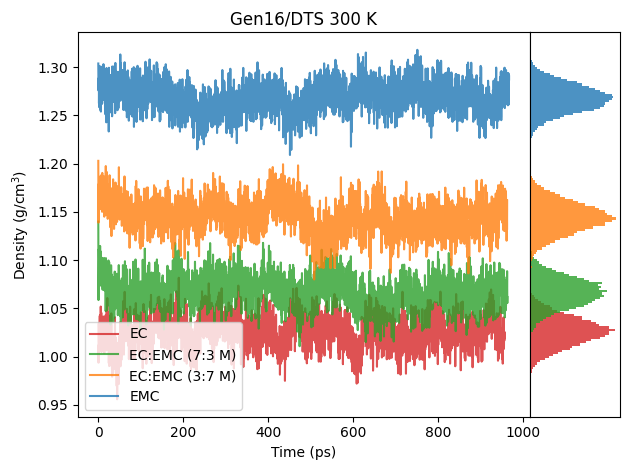

In [23]:
import glob
import numpy as np
import matplotlib.colors as mc

fnames = glob.glob('../upload/MDsimulations/1000Atoms_1000ps_NPT/Gen16DTS_PBED3/*300K.thermo')
colors = np.array([mc.to_rgb(c) for c in ['tab:red', 'tab:green', 'tab:orange', 'tab:blue']])

Navg = 1 #number of frames to average over in moving average
start = 1000 #number of frames to skip from the start of the simulation
legend = ['EC','EC:EMC (7:3 M)','EC:EMC (3:7 M)','EMC']
labs = ['Time (ps)', r'Density (g/cm$^3$)', '']

pp.plot_traj_hist(fnames, col=2, Navg=Navg, start=start, bins=50, labs=labs, colors=colors, legend=legend, title='Gen16/DTS 300 K')